# STEP 0: Decide how many samples to potentially look at

In [1]:
num_samples = 200

import torch
import numpy as np
import json

from tqdm import tqdm
from torch.autograd import Variable
import torchvision.transforms as transforms

import data
import model
import config
import utils
import data

import matplotlib.pyplot as plt
from scipy import ndimage
import cv2

from demo.vqaTools.vqa import VQA
import random
# import skimage.io as io
import os
from PIL import Image

# STEP 1: Change to your pretrained model AND the directory for your data

# Set up cell, running the cell will take a while, ONLY NEED TO RUN ONCE, just keep changing index

In [ ]:
dataDir     ='./data'
log = torch.load('logs/cg_pretrained.pth')

versionType ='v2_' # this should be '' when using VQA v2.0 dataset
taskType    ='OpenEnded' # 'OpenEnded' only for v2.0. 'OpenEnded' or 'MultipleChoice' for v1.0
dataType    ='mscoco'  # 'mscoco' only for v1.0. 'mscoco' for real and 'abstract_v002' for abstract for v1.0.
dataSubType ='val2014'
annFile     ='%s/%s_%s_annotations.json'%(dataDir, dataType, dataSubType)
quesFile    ='%s/%s%s_%s_%s_questions.json'%(dataDir, versionType, taskType, dataType, dataSubType)
imgDir      = '%s/%s/' %(dataDir, dataSubType)
vqa=VQA(annFile, quesFile)

tokens = len(log['vocab']['question']) + 1

net = torch.nn.DataParallel(model.Net(tokens)).cuda()
net.load_state_dict(log['weights'])
datavqa = data.get_VQA(val=True)

def collate_fn(batch):
    # put question lengths in descending order so that we can use packed sequences later
    batch.sort(key=lambda x: x[-1], reverse=True)
    return torch.utils.data.dataloader.default_collate(batch)

tens_loader = torch.utils.data.DataLoader(
        datavqa,
        batch_size=1,
        shuffle=False, 
        pin_memory=True,
        num_workers=config.data_workers,
        collate_fn=collate_fn,
    )

t = 0
# idxs = []
v_s, q_s, a_s, q_lens = [], [], [], [] 
for v, q, a, idx, q_len in tens_loader:
    var_params = {
            'volatile': False,
            'requires_grad': False,
        }
    v = Variable(v.cuda(async=True), **var_params)
    q = Variable(q.cuda(async=True), **var_params)
    a = Variable(a.cuda(async=True), **var_params)
    q_len = Variable(q_len.cuda(async=True), **var_params)
    v_s.append(v)
    a_s.append(a)
    q_s.append(q)
    q_lens.append(q_len)
    t += 1
    if t == num_samples: break

def apply_attention(input, attention):
    """ Apply any number of attention maps over the input. """
    n, c = input.size()[:2]
    glimpses = attention.size(1)

    # flatten the spatial dims into the third dim, since we don't need to care about how they are arranged
    input = input.view(n, 1, c, -1) # [n, 1, c, s]
    attention = attention.view(n, glimpses, -1)
    attention = torch.nn.functional.softmax(attention, dim=-1).unsqueeze(2) # [n, g, 1, s]
    weighted = attention * input # [n, g, v, s]
    weighted_mean = weighted.sum(dim=-1) # [n, g, v]
    return weighted_mean.view(n, -1), attention

def tens_to_img(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    return image

loading VQA annotations and questions into memory...
0:00:04.060887
creating index...
index created!


# This is all questions and answers for the image from the validation set,
# STEP 2: mess around with index to find a good question

Question: What is the women's racket touching?
Answer 1: floor and ball
Answer 2: ground and tennis ball
Answer 3: ground
Answer 4: ground
Answer 5: court and ball
Answer 6: ball
Answer 7: ball
Answer 8: ball
Answer 9: ground/ball
Answer 10: ball
Question: What is stretched across the court?
Answer 1: net
Answer 2: tennis net
Answer 3: net
Answer 4: net
Answer 5: net
Answer 6: net
Answer 7: net
Answer 8: net
Answer 9: net
Answer 10: net
Question: Does the man enjoy tennis?
Answer 1: yes
Answer 2: yes
Answer 3: yes
Answer 4: yes
Answer 5: yes
Answer 6: yes
Answer 7: yes
Answer 8: yes
Answer 9: yes
Answer 10: yes
Question: What color is the court?
Answer 1: green
Answer 2: green
Answer 3: green
Answer 4: green
Answer 5: green
Answer 6: green
Answer 7: green
Answer 8: green
Answer 9: green
Answer 10: green
Question: Are the players tired?
Answer 1: yes
Answer 2: yes
Answer 3: yes
Answer 4: yes
Answer 5: yes
Answer 6: yes
Answer 7: yes
Answer 8: yes
Answer 9: no
Answer 10: not sure
Questio

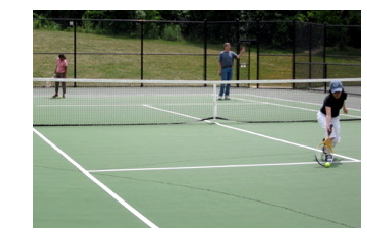

In [30]:
index = 199 # must be less than num_samples

coco_id = datavqa.coco_ids[index]
annIds = vqa.getQuesIds(imgIds=[coco_id])
anns = vqa.loadQA(annIds)
# randomAnn = random.choice(anns)
# vqa.showQA([randomAnn])  
for randomAnn in anns:
    vqa.showQA([randomAnn])  

imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
if os.path.isfile(imgDir + imgFilename):
#     I = io.imread(imgDir + imgFilename)
#     I = plt.imread(imgDir + imgFilename)
    I = Image.open(imgDir + imgFilename).convert('RGB')
    plt.imshow(I)
    plt.axis('off')
    plt.show()

# This is the question given to the network,
# STEP 3: Check if this is a good question with appropriate answers with above 

In [31]:
# find questions that have good answers
question_ind, question_len = datavqa.questions[index]
question_ind = question_ind.numpy()
voc = datavqa.vocab['question']
rev_voc = dict((v,k) for k,v in voc.items())
for i in range(question_len):
    print(rev_voc[question_ind[i]], end=' ')

does the man enjoy tennis 

# The following are the output of the network (2 attention and the answer)

/opt/conda/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


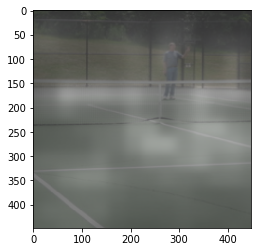

In [32]:
transform = transforms.Compose([
            transforms.Scale(config.image_size),
            transforms.CenterCrop(config.image_size),
            transforms.ToTensor(),
        ])
I_tens = transform(I)
background = tens_to_img(I_tens)
q = q_s[index]
v = v_s[index]
a = a_s[index]
q_len = q_lens[index]

net.eval()
hq = net.module.text(q, list(q_len.data))
hv = v/(v.norm(p=2, dim=1, keepdim=True).expand_as(v) + 1e-8)
ha = net.module.attention(hv, hq)
hv, attent = apply_attention(hv, ha)

tens = attent[0, 0, 0, :]
tens.shape[0]

attent_img = tens.view(14,14).to('cpu').detach().numpy()
# plt.imshow(attent_img, cmap='gray')
up_img = ndimage.zoom(attent_img, 32, order=0)
# plt.imshow(up_img, cmap='gray')
blur = ndimage.gaussian_filter(up_img, sigma=10)
# plt.imshow(blur, cmap='gray')
blur3 = 191*blur
overlay = np.stack((blur3,blur3,blur3), axis=2)
# plt.imshow(overlay)
# print(overlay.dtype)

# background = tens_to_img(npimg)
# print(type(background[0][1]))
# plt.imshow(background[0:448, 0:448])
# added_image = cv2.addWeighted(background[0:448, 0:448, :],0.4,overlay,0.1,0)
added_image = cv2.addWeighted(background, 0.4,overlay,0.1,0)
plt.imshow(added_image)


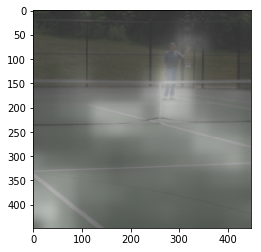

In [33]:
tens = attent[0, 1, 0, :]
tens.shape[0]

attent_img = tens.view(14,14).to('cpu').detach().numpy()
# plt.imshow(attent_img, cmap='gray')
up_img = ndimage.zoom(attent_img, 32, order=0)
# plt.imshow(up_img, cmap='gray')
blur = ndimage.gaussian_filter(up_img, sigma=10)
# plt.imshow(blur, cmap='gray')
blur3 = 191*blur
overlay = np.stack((blur3,blur3,blur3), axis=2)
# plt.imshow(overlay)
# print(overlay.dtype)

# background = tens_to_img(npimg)
# print(type(background[0][1]))
# plt.imshow(background[0:448, 0:448])
# added_image = cv2.addWeighted(background[0:448, 0:448, :],0.4,overlay,0.1,0)
added_image = cv2.addWeighted(background, 0.4,overlay,0.1,0)
plt.imshow(added_image)

In [34]:
out = net(v, q, q_len)
_, answer = out.data.cpu().max(dim=1)
answ = (answer.view(-1))
ans_voc = dict((v,k) for k,v in datavqa.answer_to_index.items())

for i in range(question_len):
    print(rev_voc[question_ind[i]], end=' ')
print("?")
print(str(ans_voc[answ.item()]))

does the man enjoy tennis ?
no
